In [22]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np

# Agent Class

In [23]:
class Agent:
  """
  id: Array index of the agent
  employed: State of the agent, whether employed or not
  """
  def __init__(self, id = 0, employed = False):
    self.id = id
    self.employed = employed
    self.strong_ties_count = 0
    self.weak_ties_count = 0
    self.strong_ties = []
    self.weak_ties = []
  def Describe(self):
    print("=============================================")
    print(f"Agent id: {self.id}")
    print(f"Employment status: {self.employed}")
    print(f"Total strong ties: {self.strong_ties_count}")
    print(f"Strong ties with Agents: {self.strong_ties}")
    print(f"Total weak ties: {self.weak_ties_count}")
    print(f"Weak ties with Agents: {self.weak_ties}")
    print("=============================================")

# Network Class

In [61]:
class Network:
  """
  Network class
  """
  def __init__(self):
    self.n_nodes = 0
    self.agents = []
  
  def Hire(self, agent):
    agent.employed = True
  
  def Fire(self, agent):
    agent.employed = False

  def Recommendation(self, agent):
    # First choose from strong ties
    strong_unemp_connections = []
    for connection in agent.strong_ties:
      if not(self.agents[connection].employed):
        strong_unemp_connections.append(connection)
    if (len(strong_unemp_connections) > 0):
      selected_connection = np.random.choice(strong_unemp_connections)
      self.Hire(self.agents[selected_connection])
    else:
      weak_unemp_connections = []
      for connection in agent.weak_ties:
        if not(self.agents[connection].employed):
          weak_unemp_connections.append(connection)
      if (len(weak_unemp_connections) > 0):
        selected_connection = np.random.choice(weak_unemp_connections)
        self.Hire(self.agents[selected_connection])

  def GetEmpUnempLists(self):
    emp_nodes_list = []
    unemp_nodes_list = []
    for node in self.agents:
      if (self.agents[node].employed):
        emp_nodes_list.append(node)
      else:
        unemp_nodes_list.append(node)
    return emp_nodes_list, unemp_nodes_list

  def SetEmpUnempLists(self, emp_nodes_list, unemp_nodes_list):
    for node in emp_nodes_list:
      self.agents[node].employed = True
    for node in unemp_nodes_list:
      self.agents[node].employed = False

  def Describe(self, show_agents = False):
    print("=============================================")
    print(f"Network with {self.n_nodes} number of nodes.")
    orphan_count = 0
    emp_count = 0
    for i in range(1, self.n_nodes):
      tie_sum = self.agents[i].strong_ties_count + self.agents[i].weak_ties_count
      if (tie_sum <= 0):
        orphan_count += 1
      if (self.agents[i].employed):
        emp_count += 1
    print(f"{orphan_count} orphaned nodes.")
    print(f"Number of employed nodes in network: {emp_count} ({(emp_count / self.n_nodes * 100):.2f}%)")
    if (self.n_nodes > 0 and show_agents):
      print(f"Details of first few nodes:")
      for i in range(1, min(self.n_nodes, 5) + 1):
        self.agents[i].Describe()
    print("=============================================")

# Generator Class

In [25]:
class Generator:
  """
  n_nodes: Total nodes to generate
  min_emp: minimum employed ratio
  max_emp: maximum employed ratio
  min_emp_ties: minimum ties for employed node
  max_emp_ties: ratio of maximum ties to total nodes in network for employed
  min_unemp_ties: by default (-1) takes value of min_emp_ties
  max_unemp_ties: by default (-1) takes value of max_emp_ties
  prob_strong_tie: probablility that a strong tie is formed
  max_strong_ties: by default (-1) is uncapped
  use_tie_cost_method: default false, overrides the normal tie assignment method
  lamda: cost of strong tie compared to weak tie
  min_tie_budget: minimum budget an agent has to assign ties
  max_tie_budget: ratio maximum budget an agent has to assign ties, to total nodes
  """
  def __init__(self, n_nodes = 100, min_emp = 0.1, max_emp = 0.4, min_emp_ties = 1,
               max_emp_ties = 0.1, min_unemp_ties = -1, max_unemp_ties = -1, prob_strong_tie = 0.1,
               max_strong_ties = -1, use_tie_cost_method = False, lamda = 2.5, min_tie_budget = 1, max_tie_budget = 0.1):
    self.n_nodes = n_nodes
    self.min_emp = int(min_emp * n_nodes)
    self.max_emp = int(max_emp * n_nodes)
    self.use_tie_cost_method = use_tie_cost_method
    if not(use_tie_cost_method):
      # Tie assignment quantities
      self.min_emp_ties = min_emp_ties
      self.max_emp_ties = int(max_emp_ties * n_nodes)
      if (min_unemp_ties > 0):
        self.min_unemp_ties = min_unemp_ties
      else:
        self.min_unemp_ties = self.min_emp_ties
      if (max_unemp_ties > 0):
        self.max_unemp_ties = int(max_unemp_ties * n_nodes)
      else:
        self.max_unemp_ties = self.max_emp_ties
      self.prob_strong_tie = prob_strong_tie
      if (max_strong_ties < 0):
        self.strong_tie_cap = False
      else:
        self.strong_tie_cap = True
        self.max_strong_ties = max_strong_ties
    else:
      # using tie cost method
      self.min_tie_budget = min_tie_budget
      self.max_tie_budget = int(max_tie_budget * n_nodes)
      self.prob_strong_tie = prob_strong_tie
      self.lamda = lamda
      
    self.gen_completed = False
    self.total_connects = 0
    self.successful_connects = 0
    self.failed_connects = 0
    self.strong_connects = 0
  
  def GenerateNetwork(self, network = None):
    """
    The original algorithm we made to generate the network.
    Populates a network with nodes and returns it.
    """
    if network is None:
      network = Network()
    all_nodes = range(1, self.n_nodes + 1)
    n_emp = np.random.choice(range(self.min_emp, self.max_emp))

    emp_nodes_list = np.random.choice(all_nodes,size = n_emp, replace=False)
    unemp_nodes_list = [x for x in all_nodes if x not in emp_nodes_list]

    if (not(self.use_tie_cost_method)):
      # Regular method for assigning ties

      edges_list = []
      node_tie_dict = {k:0 for k in all_nodes}

      max_empnode_info = {k: self.max_emp_ties for k in emp_nodes_list}
      max_unempnode_info = {k: self.max_unemp_ties for k in unemp_nodes_list}
      
      max_ties_info = {}
      max_ties_info.update(max_empnode_info)
      max_ties_info.update(max_unempnode_info)

      edge_strong = []
      edge_weak = []

      # Make connections for each node
      for node in all_nodes:
        if node in emp_nodes_list:
          num_ties = np.random.choice(range(self.min_emp_ties, self.max_emp_ties + 1))
        else:
          num_ties = np.random.choice(range(self.min_unemp_ties, self.max_unemp_ties + 1))
        connects = np.random.choice(all_nodes,size = num_ties,replace=False)
        for connect in connects:
          self.total_connects += 1
          if (connect == node or (connect, node) in edges_list):
            self.failed_connects += 1
            continue
          if node_tie_dict[connect] < max_ties_info[connect]:
            node_tie_dict[node] += 1
            node_tie_dict[connect] += 1
            edges_list.append((node,connect))
            self.successful_connects += 1
          else:
            self.failed_connects += 1

      strong_ties = []
      weak_ties = []
      strong_ties_counts = {k: 0 for k in all_nodes}

      # Assign strength to each tie
      for edge in edges_list:
        node1 = edge[0]
        node2 = edge[1]
        strong_tie_count = max(strong_ties_counts[node1], strong_ties_counts[node2])
        if np.random.random() < self.prob_strong_tie and not(self.strong_tie_cap and strong_tie_count >= self.max_strong_ties):
          strong_ties.append(edge)
          self.strong_connects += 1
        else:
          weak_ties.append(edge)
    else:
      # Tie Cost Method
      strong_ties, weak_ties = self.TieCostMethod(emp_nodes_list, unemp_nodes_list)

    # all ties have been assigned. Now to generate the Network model

    # Generate all the node objects
    node_objects_list = {}
    for node in all_nodes:
      if (node in emp_nodes_list):
        this_is_employed = True
      else:
        this_is_employed = False
      this_node_object = Agent(id = node, employed = this_is_employed)
      node_objects_list[node] = this_node_object
    
    # Settle all strong ties
    for tie in strong_ties:
      node_object_1 = node_objects_list[tie[0]]
      node_object_2 = node_objects_list[tie[1]]
      node_object_1.strong_ties.append(node_object_2.id)
      node_object_2.strong_ties.append(node_object_1.id)
      node_object_1.strong_ties_count += 1
      node_object_2.strong_ties_count += 1

    # Settle all weak ties
    for tie in weak_ties:
      node_object_1 = node_objects_list[tie[0]]
      node_object_2 = node_objects_list[tie[1]]
      node_object_1.weak_ties.append(node_object_2.id)
      node_object_2.weak_ties.append(node_object_1.id)
      node_object_1.weak_ties_count += 1
      node_object_2.weak_ties_count += 1

    # The generated network is now stored in the Network Class
    network.n_nodes = self.n_nodes
    network.agents = node_objects_list

    self.gen_completed = True

    return network
  
  def TieCostMethod(self, emp_nodes_list, unemp_nodes_list):
    all_nodes = range(1, self.n_nodes + 1)
    edges_list = []
    strong_ties = []
    weak_ties = []
    cost_dict = {k: 0 for k in all_nodes}

    for node in all_nodes:
      tie_budget = np.random.choice(range(self.min_tie_budget, self.max_tie_budget + 1))
      # Keep assigning ties as long as below tie budget
      iter_limit = self.n_nodes
      iter_count = 0
      while cost_dict[node] < tie_budget and iter_count <= iter_limit:
        iter_count += 1
        self.total_connects += 1
        # Find a node to pair with
        connect = np.random.choice(all_nodes)

        # Check if already connected, or is the same node
        if ((connect,node) in edges_list or connect == node):
          self.failed_connects += 1
          continue
        
        # Check if connection can afford a new tie
        if (cost_dict[connect] >= self.max_tie_budget):
          self.failed_connects += 1
          continue
        
        # New connection is made
        new_edge = (node,connect)
        edges_list.append(new_edge)
        self.successful_connects += 1

        # Decide to create either a strong or weak tie
        if np.random.random() < self.prob_strong_tie:
          # Create a strong tie
          strong_ties.append(new_edge)
          cost_dict[node] += self.lamda
          cost_dict[connect] += self.lamda
          self.strong_connects += 1
        else:
          # Create a weak tie
          weak_ties.append(new_edge)
          cost_dict[node] += 1
          cost_dict[connect] += 1
    
    return strong_ties, weak_ties


  def Describe(self):
    print("=============================================")
    print(f"Generator class of node capacity {self.n_nodes}.")
    print(f"Min/Max Employment counts: {self.min_emp}/{self.max_emp}")
    if (not(self.use_tie_cost_method)):
      print(f"Min/Max Employment ties: {self.min_emp_ties}/{self.max_emp_ties}")
      print(f"Min/Max Unemployment ties: {self.min_unemp_ties}/{self.max_unemp_ties}")
      print(f"Strong tie probability: {self.prob_strong_tie}")
      if (self.strong_tie_cap):
        print(f"Max strong ties per node: {self.max_strong_ties}")
    else:
      print(f"Min/Max Tie Budget: {self.min_tie_budget}/{self.max_tie_budget}")
      print(f"Strong tie probability: {self.prob_strong_tie}")
      print(f"Relative cost of strong tie: {self.lamda}")

    if (self.gen_completed):
      print(f"Generation completed. Resulted in a network of {self.n_nodes} nodes.")
      print(f"Total connections generated: {self.total_connects}")
      print(f"Successful ties made: {self.successful_connects} ({(self.successful_connects / self.total_connects * 100):.2f}%)")
      print(f"Failed tie attempts: {self.failed_connects} ({(self.failed_connects / self.total_connects * 100):.2f}%)")
      print(f"Strong ties made: {self.strong_connects} ({(self.strong_connects / self.total_connects * 100):.2f}%)")
    print("=============================================")

# Simulator Class

In [47]:
class Simulator:
  """
  hire_prob: Probability of hearing about a job in every time step
  fire_prob: Probability of being fired from existing job in every time step
  """
  def __init__(self, network, hire_prob = 0.4, fire_prob = 0.4, sim_steps = 1000):
    self.network = network
    self.alpha = hire_prob
    self.beta = fire_prob
    self.max_steps = 1000
    self.steps = 0
    self.sim_complete = False
  def SimOneTimeStep(self):
    # FIRE EVENT
    # Fire with beta probability if employed
    for agent_id in network.agents:
      agent = network.agents[agent_id]
      if agent.employed:
         if np.random.random() < self.beta:
           network.Fire(agent)
    
    # HIRE EVENT
    # Hear about job with alpha probability
    for agent_id in network.agents:
      agent = network.agents[agent_id]
      if np.random.random() < self.alpha:
        # Heard about job
        if agent.employed:
          network.Recommendation(agent)
        else:
          network.Hire(agent)
    
    self.steps += 1

  def PerformSimulation(self, sim_steps = 0):
    """
    Perform Simulation on linked Network from start to end with given settings.
    """
    if sim_steps <= 0:
      max_steps = self.max_steps + self.steps
    else:
      max_steps = sim_steps + self.steps

    self.sim_complete = False

    while not(self.sim_complete):
      self.SimOneTimeStep()
      if (self.steps >= max_steps):
        self.sim_complete = True

  def Describe(self):
    print("=============================================")
    print(f"Simulator class linked to a Network of {network.n_nodes} nodes.")
    print(f"Hire / Fire Probabilities: {self.alpha * 100:.2f}% / {self.beta * 100:.2f}%")
    print(f"Current / Maximum Simulation steps: {self.steps} / {self.max_steps}")
    if(self.sim_complete):
      print(f"Simulation completed.")
    print("=============================================")

# Plotter Class

In [67]:
class Plotter:
  def __init__(self, network, simulator, node_size = 100, tie_opacity = 0.5, figsize = (10,10), tie_width = 2, strong_tie_width_multiplier = 5):
    self.network = network
    self.simulator = simulator
    
    self.node_size = node_size
    self.tie_opacity = tie_opacity
    self.figsize = figsize
    self.tie_width = 2
    self.strong_tie_width_multiplier = 5
    self.colour_scheme = ['r', 'b']

  def GetEdgesLists(self):
    edges_list = []
    strong_ties_list = []
    weak_ties_list = []

    for node in network.agents:
      strong_ties = network.agents[node].strong_ties
      weak_ties = network.agents[node].weak_ties
      for connect in strong_ties:
        if (connect,node) not in edges_list:
          edges_list.append((node,connect))
          strong_ties_list.append((node,connect))
      for connect in weak_ties:
        if (connect,node) not in edges_list:
          edges_list.append((node,connect))
          weak_ties_list.append((node,connect))
          
    return edges_list, strong_ties_list, weak_ties_list

  def PlotNetwork(self, title = "Network Plot"):
    G1 = nx.Graph()
    nodes_list = network.agents.keys()

    # Add nodes
    G1.add_nodes_from(nodes_list)

    # Reverse-engineer the edges lists
    edges_list, strong_ties_list, weak_ties_list = self.GetEdgesLists()

    # Find employment data
    emp_nodes_list, unemp_nodes_list = self.network.GetEmpUnempLists()

    plt.figure(figsize = self.figsize)
    plt.title(title)

    pos = nx.nx_pydot.graphviz_layout(G1)
    
    # draw nodes
    nx.draw_networkx_nodes(G1, pos, node_size=self.node_size, nodelist=unemp_nodes_list, node_color=self.colour_scheme[0])
    nx.draw_networkx_nodes(G1, pos, node_size=self.node_size, nodelist=emp_nodes_list, node_color=self.colour_scheme[1])
    # draw edges
    nx.draw_networkx_edges(G1, pos, edgelist=strong_ties_list, alpha=self.tie_opacity, width= (self.strong_tie_width_multiplier * self.tie_width))
    nx.draw_networkx_edges(G1, pos, edgelist=weak_ties_list, alpha=self.tie_opacity, width=self.tie_width)
    plt.show()

  def PlotTieDist(self, title = "Tie Frequency Distribution"):
    nodes_list = network.agents.keys()
    tie_counts = []
    # Get the tie statistics
    for node in nodes_list:
      tie_count = self.network.agents[node].strong_ties_count + self.network.agents[node].weak_ties_count
      tie_counts.append(tie_count)
    
    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.hist(tie_counts)
    plt.show()

  def PlotStrongTieDist(self, title = "Strong Tie Frequency Distribution", fractional_dist = False, only_employed = False, only_unemployed = False):
    nodes_list = network.agents.keys()

    if only_employed:
      emp_nodes_list, unemp_nodes_list = self.network.GetEmpUnempLists()
      nodes_list = emp_nodes_list
    elif only_unemployed:
      emp_nodes_list, unemp_nodes_list = self.network.GetEmpUnempLists()
      nodes_list = unemp_nodes_list

    strong_tie_counts = []
    # Get the tie statistics
    for node in nodes_list:
      strong_tie_count = self.network.agents[node].strong_ties_count
      weak_tie_count = self.network.agents[node].weak_ties_count
      tie_count = strong_tie_count + weak_tie_count
      if (fractional_dist and tie_count > 0):
        strong_tie_counts.append(strong_tie_count / tie_count)
      else:
        strong_tie_counts.append(strong_tie_count)
    
    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.hist(strong_tie_counts)
    plt.show()

  def PlotEmploymentChanceVsStrongTieFrac(self, sim_steps = 100, n_realisations = 1, pre_steps = 0, title = "Employment Chance vs Strong Tie Fraction"):

    nodes_list = network.agents.keys()
    
    emp_list, unemp_list = self.network.GetEmpUnempLists()

    avg_emp_timestep_fracs = np.zeros(len(nodes_list))

    for realisation in range(n_realisations):
      self.network.SetEmpUnempLists(emp_list, unemp_list)

      agent_data_dict = {k: [0,0] for k in nodes_list}
      steps = 0
      while steps < sim_steps:
        steps += 1
        self.simulator.SimOneTimeStep()
        for node in nodes_list:
          if self.network.agents[node].employed:
            agent_data_dict[node][0] += 1
      
      for node in nodes_list:
        strong_tie_count = self.network.agents[node].strong_ties_count
        weak_tie_count = self.network.agents[node].weak_ties_count
        tie_count = strong_tie_count + weak_tie_count
        if (tie_count <= 0):
          agent_data_dict[node][1] = 0
        else:
          agent_data_dict[node][1] = (strong_tie_count / tie_count)
      
      emp_timestep_counts, strong_tie_fracs = zip(*agent_data_dict.values())
      emp_timestep_fracs = np.asarray([count / sim_steps for count in emp_timestep_counts])
      avg_emp_timestep_fracs += emp_timestep_fracs / n_realisations

    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.scatter(strong_tie_fracs , avg_emp_timestep_fracs)
    plt.xlabel('Fraction of Strang Ties')
    plt.ylabel(f'Average Employment % over {sim_steps} steps')
    plt.show()

  def Describe(self):
    print("=============================================")
    print(f"Plotter for Network of {self.network.n_nodes} Nodes.")
    print("=============================================")

# Example Script

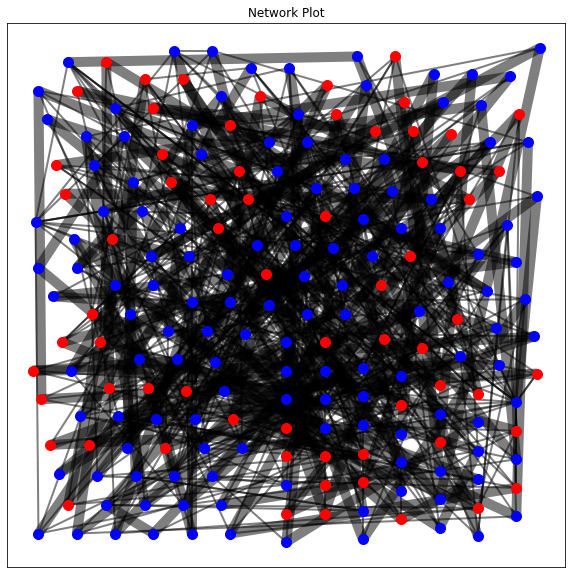

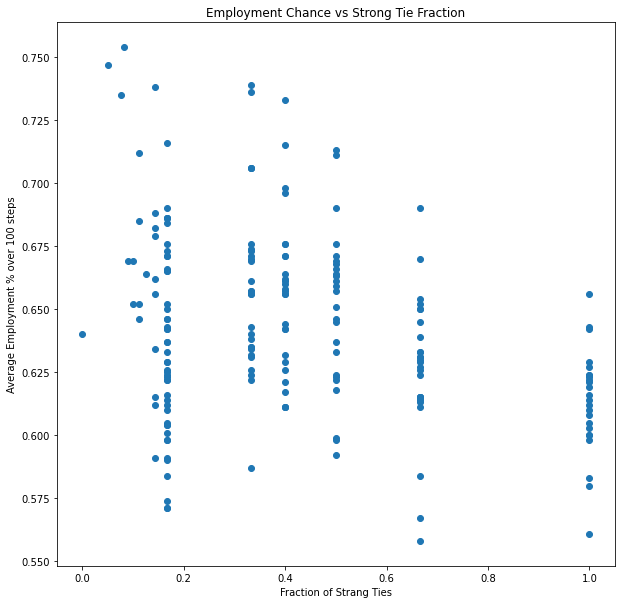

In [76]:
generator = Generator(n_nodes= 200 , use_tie_cost_method= True, prob_strong_tie= 0.3, min_tie_budget= 20, max_tie_budget = 0.101, lamda = 15)

network = generator.GenerateNetwork()

simulator = Simulator(network, fire_prob= 0.6)
simulator.PerformSimulation()

plotter = Plotter(network, simulator)

plotter.PlotNetwork()
plotter.PlotEmploymentChanceVsStrongTieFrac(n_realisations = 10)